In [1]:
import torch
import torchvision.datasets as datasets

In [2]:
DATA_PATH = '/home/ujjwal/Desktop/BVAA/data/'

In [3]:
train_batch_size = 64
test_batch_size = 1000

In [4]:
import torchvision.transforms as transforms

train_loader = torch.utils.data.DataLoader(datasets.MNIST(DATA_PATH, train=True, download=True,
                             transform=transforms.Compose([
                                 transforms.ToTensor(),
                                 transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])), batch_size=train_batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(datasets.MNIST(DATA_PATH, train=False, download=True,
                                                        transform=transforms.Compose([
                                                            transforms.ToTensor(),
                                                            transforms.Normalize(
                                                            (0.1307,), (0.3081,))
                                                        ])), batch_size=test_batch_size, shuffle=True)

In [5]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

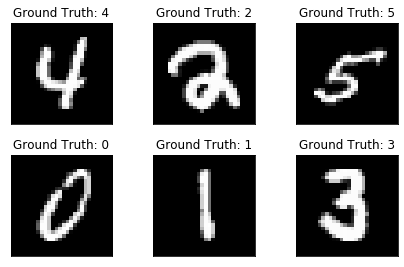

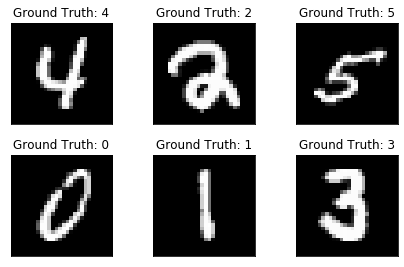

In [6]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])
fig

In [10]:
example_data[0].shape

torch.Size([1, 28, 28])

In [7]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [12]:
def conv(inch, ouch, ks, stride=2, pad=1, batchNorm=True):
    layers = []
    
    layers.append(nn.Conv2d(inch, ouch, ks, pad))
    
    if batchNorm:
        layers.append(nn.BatchNorm2d(ouch))
    
    return nn.Sequential(*layers)

In [13]:
class Encoder(nn.Module):
    def __init__(self, net_depth=4, conv_dim=64, img_dim=28, nc=1, z_dim=64):
        super(Encoder, self).__init__()
        self.net_depth = net_depth
        
        kernel_size = 4
        stride = 2
        pad = 1
        input_ch = nc
        output_ch = conv_dim
        
        self.encoder = []
        
        self.encoder.extend([conv(input_ch, output_ch, kernel_size, stride, pad, batchNorm=False), nn.LeakyReLU(0.05)])
        
        map_dim = (img_dim - kernel_size + 2 * pad) / stride + 1
        
        for i in range(1,net_depth):
            input_ch = output_ch
            output_ch = conv_dim*(2**i)
            self.encoder.extend([conv(input_ch, output_ch, kernel_size, stride, pad, batchNorm=False), nn.LeakyReLU(0.05)])
            map_dim = (map_dim - kernel_size + 2 * pad) / stride + 1
        
        self.encoder = nn.Sequential(*self.encoder)
        
        self.fc = nn.Linear(output_ch*(map_dim**2), 2048)
        self.fc1 = nn.Linear(2048, 1024)
        self.fc2 = nn.Linear(1024, z_dim)
    
    def encode(self, x):
        out = self.encoder(x)
        out = out.view((-1, torch.prod(torch.tensor(out.size()), 0).item()))
        out = F.leaky_relu(self.fc(out), 0.05)
        out = F.leaky_relu(self.fc1(out), 0.05)
        out = self.fc2(out)
        return out
    
    def forward(self, x):
        return self.encode(x)

In [14]:
def deconv(inch, ouch, kernel_size, stride=2, pad=1, batchNorm=True):
    layers = []
    layers.append(nn.ConvTranspose2d(inch, ouch, kernel_size, stride, pad))
    if batchNorm:
        layers.append(nn.BatchNorm2d(ouch))
    return nn.Sequential(*layers)

In [15]:
class Decoder(nn.Module):
    def __init__(self, net_depth=4, conv_dim=64, img_dim=28, nc=1, z_dim=32):
        super(Decoder, self).__init__()
        self.net_depth = net_depth
        
        kernel_size = 4
        stride = 2
        pad = 1
        input_ch = z_dim
        output_ch = conv_dim*(2**self.net_depth)
        map_dim = k
        
        self.fc = deconv(input_ch, output_ch, kernel_size, stride=1, pad=0, batchNorm=False)
        
        self.decoder = []
        
        for i in reversed(range(self.net_depth)):
            input_ch = output_ch
            output_ch = conv_dim*(2**i)
            self.decoder.extend([deconv(input_ch, output_ch, kernel_size, stride, pad, batchNorm=False), nn.LeakyReLU(0.05)])
            map_dim = kernel_size - 2 * pad + stride * (map_dim - 1)
        
        self.decoder = nn.Sequential(*self.decoder)
        
        input_ch = output_ch
        output_ch = 1
        output_dim = img_dim
        pad = 0
        stride = 1
        kernel_size = output_dim + 2 * pad - stride * (map_dim - 1)
        self.final = deconv(input_ch, output_ch, kernel_size, stride, pad, batchNorm=False)
        
    def decode(self, z):
        z = z.view(z.size(0), z.size(1), 1, 1)
        out = F.leaky_relu(self.fc(z), 0.05)
        out = F.leaky_relu(self.decoder(out), 0.05)
        out = F.sigmoid(self.final(out))
        return out
    
    def forward(self, z):
        return self.decode(z)

In [16]:
class betaVAE(nn.Module):
    def __init__(self, net_depth=4, conv_dim=64, img_dim=28, nc=1, z_dim=32, beta=1.0, use_cuda=True):
        super(Net, self).__init__()
        self.encoder = Encoder(net_depth, conv_dim, img_dim, nc, z_dim=2*z_dim)
        self.decoder = Decoder(net_depth, conv_dim, img_dim, nc, z_dim)
        self.beta = beta
        self.use_cuda = use_cuda
        if self.use_cuda:
            self.cuda()
    
    def reparameterize(self, mu, log_var):
        eps = torch.randn(mu.size(), requires_grad=False).cuda()
        return mu + eps * torch.exp(log_var/2)
    
    def forward(self, x):
        h = self.encoder(x)
        mu, log_var = torch.chunk(h, 2, dim=1)
        z = self.reparameterize(mu, log_var)
        out = self.decoder(z)
        return out, mu, log_var

In [18]:
nn.Module._module

AttributeError: type object 'Module' has no attribute '_module'